<a href="https://colab.research.google.com/github/cboomus/Spirometric_Norms/blob/main/Transfer_Learning_TB_CXR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 978 images belonging to 2 classes.
Found 280 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Epoch 1/10
30/30 [==============================] - 307s 10s/step - loss: 0.4856 - accuracy: 0.7537 - val_loss: 0.2568 - val_accuracy: 0.8945
Epoch 2/10
30/30 [==============================] - 327s 11s/step - loss: 0.3025 - accuracy: 0.8795 - val_loss: 0.2018 - val_accuracy: 0.9258
Epoch 3/10
30/30 [==============================] - 318s 11s/step - loss: 0.2348 - accuracy: 0.9165 - val_loss: 0.1889 - val_accuracy: 0.9102
Epoch 4/10
30/30 [==============================] - 303s 10s/step - loss: 0.1968 - accuracy: 0.9366 - val_loss: 0.1446 - val_accuracy: 0.9492
Epoch 5/10
30/30 [==============================] - 321s 11s/step - loss: 0.1753 - accuracy: 0.9366 - val_loss: 0.1514 - val_accuracy: 0.9414
Epoch 6/10
30/30 [==============================] - 320s 11s/step - loss: 0.1721 - accuracy: 0.9482 - val_loss: 0.1373 - val_accuracy: 0.9531
Epoch 7/10
30/30 [=======

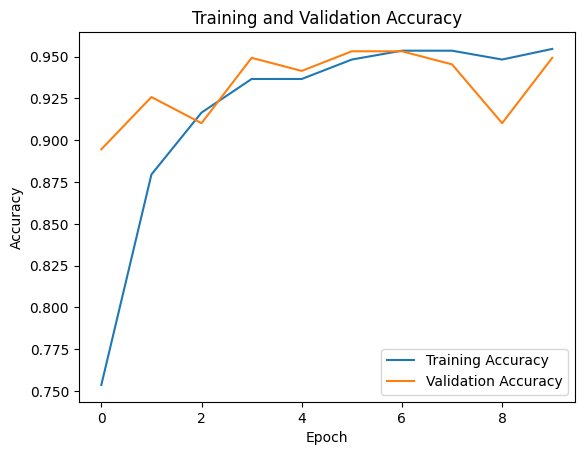

4/4 [==============================] - 29s 7s/step - loss: 0.1656 - accuracy: 0.9141
Test loss: 0.16563060879707336, Test accuracy: 0.9140625


In [9]:
# Import libraries
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# define a function to split the data into train, validation, and test
def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.2):
    classes = ['positive', 'negative']
    for cls in classes:
        if cls == "positive":
            src_folder = '/content/drive/MyDrive/SAT5114_Final_Project/Tuberculosis'
        else:
            src_folder = '/content/drive/MyDrive/SAT5114_Final_Project/Normal'

        train_folder = os.path.join(train_dir, cls)
        val_folder = os.path.join(val_dir, cls)
        test_folder = os.path.join(test_dir, cls)

        # Make sure train, validation, and test folders exist
        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(val_folder, exist_ok=True)
        os.makedirs(test_folder, exist_ok=True)

        # Get all the images and shuffle them
        images = [os.path.join(src_folder, img) for img in os.listdir(src_folder)]
        np.random.shuffle(images)

        # Calculate the number of images for each split
        total_images = len(images)
        train_count = int(total_images * train_size)
        val_count = int(total_images * val_size)
        test_count = total_images - train_count - val_count

        # Split images
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        # Move images to their respective folders
        for img in train_images:
            shutil.move(img, os.path.join(train_folder, os.path.basename(img)))
        for img in val_images:
            shutil.move(img, os.path.join(val_folder, os.path.basename(img)))
        for img in test_images:
            shutil.move(img, os.path.join(test_folder, os.path.basename(img)))

# Define directories
base_dir = 'path_to_dataset'
source_dir = os.path.join(base_dir, 'source')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Split the data
split_data(source_dir, train_dir, validation_dir, test_dir)

# Image processing parameters
img_width, img_height = 299, 299  # Resize target for InceptionV3
batch_size = 32
epochs = 10

# Data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Normalize the pixel values
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Load and configure model
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model using the test set
loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')
